<a href="https://colab.research.google.com/github/manthanawgan/MLops/blob/main/Duration_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import root_mean_squared_error


In [3]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

In [11]:
import mlflow 

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment("exp1-duration-detection")


<Experiment: artifact_location='file:///d:/coding/Learning/MLops/02-experiment-tracking/mlruns/1', creation_time=1746204838744, experiment_id='1', last_update_time=1746204838744, lifecycle_stage='active', name='exp1-duration-detection', tags={}>

In [12]:
import pickle

In [13]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [14]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [15]:
len(df_train), len(df_val)

(73908, 61921)

In [16]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [17]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [18]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [19]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715205596356

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21128\3130867531.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='prediction')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21128\3130867531.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='actual')


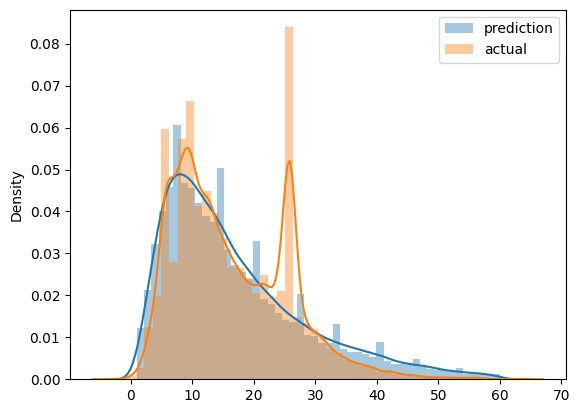

In [13]:
sns.distplot(y_train, label='prediction')
sns.distplot(y_pred, label='actual')

plt.legend()

In [20]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [21]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Manthan")
    mlflow.log_param("train-data","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data","./data/green_tripdata_2021-02.parquet")

    

    alpha = 0.0001
    mlflow.log_param("alpha", alpha)
    ls = Lasso(alpha)
    ls.fit(X_train, y_train)

    y_pred = ls.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    print(rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

KeyboardInterrupt: 

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

In [9]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain = dtrain,
            num_boost_round = 1000,
            evals = [(dvalid, 'valid')],
            early_stopping_rounds = 50
        )
        y_pred = booster.predict(dvalid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)
    return {'loss' : rmse, 'status' : STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),       
    'learning_rate': hp.loguniform('learning_rate', -3, 0),   # will return value from exp(-3) to exp(0)  range --> (0.05 to 1)
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),        
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),      
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:40:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.63081                               
[1]	valid-rmse:11.10525                               
[2]	valid-rmse:10.62919                               
[3]	valid-rmse:10.19515                               
[4]	valid-rmse:9.80951                                
[5]	valid-rmse:9.45837                                
[6]	valid-rmse:9.14859                                
[7]	valid-rmse:8.86559                                
[8]	valid-rmse:8.61271                                
[9]	valid-rmse:8.39052                                
[10]	valid-rmse:8.19224                               
[11]	valid-rmse:8.01124                               
[12]	valid-rmse:7.85063                               
[13]	valid-rmse:7.71275                               
[14]	valid-rmse:7.58375                               
[15]	valid-rmse:7.47486                               
[16]	valid-rmse:7.37707                               
[17]	valid-rmse:7.28722                               
[18]	valid

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:44:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.75562                                                           
[1]	valid-rmse:11.33210                                                           
[2]	valid-rmse:10.94054                                                           
[3]	valid-rmse:10.57905                                                           
[4]	valid-rmse:10.24579                                                           
[5]	valid-rmse:9.93887                                                            
[6]	valid-rmse:9.65611                                                            
[7]	valid-rmse:9.39625                                                            
[8]	valid-rmse:9.15813                                                            
[9]	valid-rmse:8.93968                                                            
[10]	valid-rmse:8.73991                                                           
[11]	valid-rmse:8.55690                                                           
[12]

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:45:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.45223                                                           
[1]	valid-rmse:10.78540                                                           
[2]	valid-rmse:10.20384                                                           
[3]	valid-rmse:9.69767                                                            
[4]	valid-rmse:9.25906                                                            
[5]	valid-rmse:8.87989                                                            
[6]	valid-rmse:8.55390                                                            
[7]	valid-rmse:8.27371                                                            
[8]	valid-rmse:8.03452                                                            
[9]	valid-rmse:7.83040                                                            
[10]	valid-rmse:7.65606                                                           
[11]	valid-rmse:7.50828                                                           
[12]

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:47:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:6.83980                                                            
[1]	valid-rmse:6.75836                                                            
[2]	valid-rmse:6.74387                                                            
[3]	valid-rmse:6.72962                                                            
[4]	valid-rmse:6.72256                                                            
[5]	valid-rmse:6.72149                                                            
[6]	valid-rmse:6.71294                                                            
[7]	valid-rmse:6.70638                                                            
[8]	valid-rmse:6.70885                                                            
[9]	valid-rmse:6.69833                                                            
[10]	valid-rmse:6.70035                                                           
[11]	valid-rmse:6.69922                                                           
[12]

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:47:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:9.13467                                                           
[1]	valid-rmse:7.68829                                                           
[2]	valid-rmse:7.04777                                                           
[3]	valid-rmse:6.76693                                                           
[4]	valid-rmse:6.63762                                                           
[5]	valid-rmse:6.56991                                                           
[6]	valid-rmse:6.52582                                                           
[7]	valid-rmse:6.50491                                                           
[8]	valid-rmse:6.49200                                                           
[9]	valid-rmse:6.47533                                                           
[10]	valid-rmse:6.46578                                                          
[11]	valid-rmse:6.45832                                                          
[12]	valid-rmse:

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:48:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:7.19000                                                           
[1]	valid-rmse:6.62397                                                           
[2]	valid-rmse:6.52952                                                           
[3]	valid-rmse:6.50766                                                           
[4]	valid-rmse:6.49153                                                           
[5]	valid-rmse:6.47526                                                           
[6]	valid-rmse:6.46807                                                           
[7]	valid-rmse:6.45882                                                           
[8]	valid-rmse:6.45246                                                           
[9]	valid-rmse:6.44499                                                           
[10]	valid-rmse:6.44104                                                          
[11]	valid-rmse:6.43706                                                          
[12]	valid-rmse:

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:50:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:9.49616                                                          
[1]	valid-rmse:8.02864                                                          
[2]	valid-rmse:7.27611                                                          
[3]	valid-rmse:6.90484                                                          
[4]	valid-rmse:6.71571                                                          
[5]	valid-rmse:6.61260                                                          
[6]	valid-rmse:6.55519                                                          
[7]	valid-rmse:6.51814                                                          
[8]	valid-rmse:6.49525                                                          
[9]	valid-rmse:6.47791                                                          
[10]	valid-rmse:6.46704                                                         
[11]	valid-rmse:6.45952                                                         
[12]	valid-rmse:6.45027     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:51:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.30743                                                        
[1]	valid-rmse:10.53573                                                        
[2]	valid-rmse:9.88206                                                         
[3]	valid-rmse:9.33052                                                         
[4]	valid-rmse:8.86820                                                         
[5]	valid-rmse:8.48283                                                         
[6]	valid-rmse:8.16294                                                         
[7]	valid-rmse:7.89810                                                         
[8]	valid-rmse:7.67934                                                         
[9]	valid-rmse:7.49901                                                         
[10]	valid-rmse:7.35150                                                        
[11]	valid-rmse:7.22933                                                        
[12]	valid-rmse:7.12910                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:53:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:6.83837                                                           
[1]	valid-rmse:6.70711                                                           
[2]	valid-rmse:6.69030                                                           
[3]	valid-rmse:6.68305                                                           
[4]	valid-rmse:6.67236                                                           
[5]	valid-rmse:6.65992                                                           
[6]	valid-rmse:6.65373                                                           
[7]	valid-rmse:6.64921                                                           
[8]	valid-rmse:6.64611                                                           
[9]	valid-rmse:6.64359                                                           
[10]	valid-rmse:6.63961                                                          
[11]	valid-rmse:6.63592                                                          
[12]	valid-rmse:

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:54:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:8.28436                                                         
[1]	valid-rmse:7.04943                                                         
[2]	valid-rmse:6.68186                                                         
[3]	valid-rmse:6.56014                                                         
[4]	valid-rmse:6.50505                                                         
[5]	valid-rmse:6.48009                                                         
[6]	valid-rmse:6.46583                                                         
[7]	valid-rmse:6.45429                                                         
[8]	valid-rmse:6.44905                                                         
[9]	valid-rmse:6.44461                                                         
[10]	valid-rmse:6.43922                                                        
[11]	valid-rmse:6.43519                                                        
[12]	valid-rmse:6.43118                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:55:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.35706                                                         
[1]	valid-rmse:10.62028                                                         
[2]	valid-rmse:9.98989                                                          
[3]	valid-rmse:9.44937                                                          
[4]	valid-rmse:8.99371                                                          
[5]	valid-rmse:8.59893                                                          
[6]	valid-rmse:8.27754                                                          
[7]	valid-rmse:7.99884                                                          
[8]	valid-rmse:7.76753                                                          
[9]	valid-rmse:7.57096                                                          
[10]	valid-rmse:7.40837                                                         
[11]	valid-rmse:7.27783                                                         
[12]	valid-rmse:7.16506     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:57:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:8.73726                                                            
[1]	valid-rmse:7.35417                                                            
[2]	valid-rmse:6.84064                                                            
[3]	valid-rmse:6.64810                                                            
[4]	valid-rmse:6.55976                                                            
[5]	valid-rmse:6.51253                                                            
[6]	valid-rmse:6.49096                                                            
[7]	valid-rmse:6.47610                                                            
[8]	valid-rmse:6.46630                                                            
[9]	valid-rmse:6.45706                                                            
[10]	valid-rmse:6.45266                                                           
[11]	valid-rmse:6.44701                                                           
[12]

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [17:58:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.72511                                                         
[1]	valid-rmse:11.27537                                                         
[2]	valid-rmse:10.86166                                                         
[3]	valid-rmse:10.48164                                                         
[4]	valid-rmse:10.13309                                                         
[5]	valid-rmse:9.81359                                                          
[6]	valid-rmse:9.52148                                                          
[7]	valid-rmse:9.25448                                                          
[8]	valid-rmse:9.01067                                                          
[9]	valid-rmse:8.78917                                                          
[10]	valid-rmse:8.58762                                                         
[11]	valid-rmse:8.40424                                                         
[12]	valid-rmse:8.23811     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:00:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:7.22247                                                          
[1]	valid-rmse:6.61056                                                          
[2]	valid-rmse:6.50899                                                          
[3]	valid-rmse:6.47675                                                          
[4]	valid-rmse:6.46024                                                          
[5]	valid-rmse:6.44979                                                          
[6]	valid-rmse:6.44110                                                          
[7]	valid-rmse:6.43039                                                          
[8]	valid-rmse:6.41584                                                          
[9]	valid-rmse:6.41247                                                          
[10]	valid-rmse:6.40672                                                         
[11]	valid-rmse:6.40255                                                         
[12]	valid-rmse:6.40074     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:00:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.62922                                                         
[1]	valid-rmse:11.09951                                                         
[2]	valid-rmse:10.62003                                                         
[3]	valid-rmse:10.18728                                                         
[4]	valid-rmse:9.79724                                                          
[5]	valid-rmse:9.44654                                                          
[6]	valid-rmse:9.13091                                                          
[7]	valid-rmse:8.84869                                                          
[8]	valid-rmse:8.59592                                                          
[9]	valid-rmse:8.36958                                                          
[10]	valid-rmse:8.16804                                                         
[11]	valid-rmse:7.98892                                                         
[12]	valid-rmse:7.82932     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:01:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.61318                                                         
[1]	valid-rmse:9.44152                                                          
[2]	valid-rmse:8.59562                                                          
[3]	valid-rmse:7.99566                                                          
[4]	valid-rmse:7.57516                                                          
[5]	valid-rmse:7.28257                                                          
[6]	valid-rmse:7.07877                                                          
[7]	valid-rmse:6.93810                                                          
[8]	valid-rmse:6.83886                                                          
[9]	valid-rmse:6.76898                                                          
[10]	valid-rmse:6.71895                                                         
[11]	valid-rmse:6.67992                                                         
[12]	valid-rmse:6.65117     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:02:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.68155                                                         
[1]	valid-rmse:11.19434                                                         
[2]	valid-rmse:10.75110                                                         
[3]	valid-rmse:10.34854                                                         
[4]	valid-rmse:9.97863                                                          
[5]	valid-rmse:9.64724                                                          
[6]	valid-rmse:9.34002                                                          
[7]	valid-rmse:9.06932                                                          
[8]	valid-rmse:8.82005                                                          
[9]	valid-rmse:8.59536                                                          
[10]	valid-rmse:8.39528                                                         
[11]	valid-rmse:8.21245                                                         
[12]	valid-rmse:8.04469     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:05:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.15496                                                         
[1]	valid-rmse:10.28092                                                         
[2]	valid-rmse:9.56401                                                          
[3]	valid-rmse:8.97617                                                          
[4]	valid-rmse:8.50386                                                          
[5]	valid-rmse:8.12072                                                          
[6]	valid-rmse:7.81212                                                          
[7]	valid-rmse:7.56642                                                          
[8]	valid-rmse:7.37593                                                          
[9]	valid-rmse:7.22209                                                          
[10]	valid-rmse:7.10221                                                         
[11]	valid-rmse:7.00082                                                         
[12]	valid-rmse:6.92070     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:06:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.52450                                                         
[1]	valid-rmse:9.29989                                                          
[2]	valid-rmse:8.42920                                                          
[3]	valid-rmse:7.81967                                                          
[4]	valid-rmse:7.40221                                                          
[5]	valid-rmse:7.11334                                                          
[6]	valid-rmse:6.91756                                                          
[7]	valid-rmse:6.78433                                                          
[8]	valid-rmse:6.68746                                                          
[9]	valid-rmse:6.62456                                                          
[10]	valid-rmse:6.57733                                                         
[11]	valid-rmse:6.54264                                                         
[12]	valid-rmse:6.51477     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:07:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.56008                                                        
[1]	valid-rmse:9.35801                                                         
[2]	valid-rmse:8.50199                                                         
[3]	valid-rmse:7.90011                                                         
[4]	valid-rmse:7.48503                                                         
[5]	valid-rmse:7.19884                                                         
[6]	valid-rmse:7.00187                                                         
[7]	valid-rmse:6.86859                                                         
[8]	valid-rmse:6.77554                                                         
[9]	valid-rmse:6.71062                                                         
[10]	valid-rmse:6.66189                                                        
[11]	valid-rmse:6.62583                                                        
[12]	valid-rmse:6.60049                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:08:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:9.69020                                                         
[1]	valid-rmse:8.23036                                                         
[2]	valid-rmse:7.41882                                                         
[3]	valid-rmse:6.98510                                                         
[4]	valid-rmse:6.74973                                                         
[5]	valid-rmse:6.62447                                                         
[6]	valid-rmse:6.55303                                                         
[7]	valid-rmse:6.50212                                                         
[8]	valid-rmse:6.47268                                                         
[9]	valid-rmse:6.45395                                                         
[10]	valid-rmse:6.44013                                                        
[11]	valid-rmse:6.43116                                                        
[12]	valid-rmse:6.42444                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:09:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:9.82284                                                         
[1]	valid-rmse:8.38348                                                         
[2]	valid-rmse:7.54385                                                         
[3]	valid-rmse:7.07356                                                         
[4]	valid-rmse:6.81196                                                         
[5]	valid-rmse:6.66844                                                         
[6]	valid-rmse:6.58131                                                         
[7]	valid-rmse:6.52615                                                         
[8]	valid-rmse:6.49129                                                         
[9]	valid-rmse:6.46935                                                         
[10]	valid-rmse:6.45230                                                        
[11]	valid-rmse:6.44133                                                        
[12]	valid-rmse:6.43091                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:10:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	valid-rmse:7.60396                                                         
[4]	valid-rmse:7.28450                                                         
[5]	valid-rmse:7.08664                                                         
[6]	valid-rmse:6.96324                                                         
[7]	valid-rmse:6.88363                                                         
[8]	valid-rmse:6.83241                                                         
[9]	valid-rmse:6.80087                                                         
[10]	valid-rmse:6.77498                                                        
[11]	valid-rmse:6.75910                                                        
[12]	valid-rmse:6.74895                                                        
[13]	valid-rmse:6.74007                                                        
[14]	valid-rmse:6.73530                                                        
[15]	valid-rmse:6.72912                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:10:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.78039                                                        
[1]	valid-rmse:9.68569                                                         
[2]	valid-rmse:8.86793                                                         
[3]	valid-rmse:8.24381                                                         
[4]	valid-rmse:7.79681                                                         
[5]	valid-rmse:7.47605                                                         
[6]	valid-rmse:7.23694                                                         
[7]	valid-rmse:7.05566                                                         
[8]	valid-rmse:6.93290                                                         
[9]	valid-rmse:6.84013                                                         
[10]	valid-rmse:6.77056                                                        
[11]	valid-rmse:6.71661                                                        
[12]	valid-rmse:6.67579                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:12:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.87880                                                        
[1]	valid-rmse:9.83073                                                         
[2]	valid-rmse:9.02225                                                         
[3]	valid-rmse:8.39999                                                         
[4]	valid-rmse:7.92888                                                         
[5]	valid-rmse:7.57200                                                         
[6]	valid-rmse:7.30554                                                         
[7]	valid-rmse:7.10434                                                         
[8]	valid-rmse:6.95992                                                         
[9]	valid-rmse:6.84530                                                         
[10]	valid-rmse:6.75953                                                        
[11]	valid-rmse:6.69485                                                        
[12]	valid-rmse:6.64526                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:13:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.98896                                                         
[1]	valid-rmse:10.01402                                                         
[2]	valid-rmse:9.23727                                                          
[3]	valid-rmse:8.64130                                                          
[4]	valid-rmse:8.17036                                                          
[5]	valid-rmse:7.80916                                                          
[6]	valid-rmse:7.53031                                                          
[7]	valid-rmse:7.31362                                                          
[8]	valid-rmse:7.15581                                                          
[9]	valid-rmse:7.03584                                                          
[10]	valid-rmse:6.93686                                                         
[11]	valid-rmse:6.86155                                                         
[12]	valid-rmse:6.80212     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:14:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.98348                                                         
[1]	valid-rmse:9.99630                                                          
[2]	valid-rmse:9.21406                                                          
[3]	valid-rmse:8.59784                                                          
[4]	valid-rmse:8.11888                                                          
[5]	valid-rmse:7.74739                                                          
[6]	valid-rmse:7.46109                                                          
[7]	valid-rmse:7.24084                                                          
[8]	valid-rmse:7.07055                                                          
[9]	valid-rmse:6.94271                                                          
[10]	valid-rmse:6.84191                                                         
[11]	valid-rmse:6.76426                                                         
[12]	valid-rmse:6.70336     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:15:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.50767                                                         
[1]	valid-rmse:10.88117                                                         
[2]	valid-rmse:10.32632                                                         
[3]	valid-rmse:9.83678                                                          
[4]	valid-rmse:9.40540                                                          
[5]	valid-rmse:9.02586                                                          
[6]	valid-rmse:8.69434                                                          
[7]	valid-rmse:8.40403                                                          
[8]	valid-rmse:8.15194                                                          
[9]	valid-rmse:7.93332                                                          
[10]	valid-rmse:7.74353                                                         
[11]	valid-rmse:7.57829                                                         
[12]	valid-rmse:7.43572     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:16:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.53504                                                         
[1]	valid-rmse:10.92970                                                         
[2]	valid-rmse:10.39095                                                         
[3]	valid-rmse:9.91361                                                          
[4]	valid-rmse:9.49002                                                          
[5]	valid-rmse:9.11533                                                          
[6]	valid-rmse:8.78558                                                          
[7]	valid-rmse:8.49546                                                          
[8]	valid-rmse:8.24257                                                          
[9]	valid-rmse:8.02103                                                          
[10]	valid-rmse:7.82856                                                         
[11]	valid-rmse:7.66139                                                         
[12]	valid-rmse:7.51477     

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:18:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.43588                                                        
[1]	valid-rmse:10.75712                                                        
[2]	valid-rmse:10.16536                                                        
[3]	valid-rmse:9.65537                                                         
[4]	valid-rmse:9.20943                                                         
[5]	valid-rmse:8.83111                                                         
[6]	valid-rmse:8.50418                                                         
[7]	valid-rmse:8.22257                                                         
[8]	valid-rmse:7.98523                                                         
[9]	valid-rmse:7.77958                                                         
[10]	valid-rmse:7.60676                                                        
[11]	valid-rmse:7.46030                                                        
[12]	valid-rmse:7.33271                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:20:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	valid-rmse:11.41102                                                        
[2]	valid-rmse:11.05038                                                        
[3]	valid-rmse:10.71484                                                        
[4]	valid-rmse:10.40267                                                        
[5]	valid-rmse:10.11300                                                        
[6]	valid-rmse:9.84403                                                         
[7]	valid-rmse:9.59471                                                         
[8]	valid-rmse:9.36427                                                         
[9]	valid-rmse:9.15059                                                         
[10]	valid-rmse:8.95327                                                        
[11]	valid-rmse:8.77109                                                        
[12]	valid-rmse:8.60274                                                        
[13]	valid-rmse:8.44867                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:20:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.55233                                                        
[1]	valid-rmse:10.96135                                                        
[2]	valid-rmse:10.43399                                                        
[3]	valid-rmse:9.96409                                                         
[4]	valid-rmse:9.54762                                                         
[5]	valid-rmse:9.17836                                                         
[6]	valid-rmse:8.85283                                                         
[7]	valid-rmse:8.56504                                                         
[8]	valid-rmse:8.31375                                                         
[9]	valid-rmse:8.09254                                                         
[10]	valid-rmse:7.89844                                                        
[11]	valid-rmse:7.72725                                                        
[12]	valid-rmse:7.57858                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:22:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.54712                                                        
[1]	valid-rmse:10.95388                                                        
[2]	valid-rmse:10.42720                                                        
[3]	valid-rmse:9.96116                                                         
[4]	valid-rmse:9.54947                                                         
[5]	valid-rmse:9.18697                                                         
[6]	valid-rmse:8.86867                                                         
[7]	valid-rmse:8.58986                                                         
[8]	valid-rmse:8.34631                                                         
[9]	valid-rmse:8.13380                                                         
[10]	valid-rmse:7.94925                                                        
[11]	valid-rmse:7.78844                                                        
[12]	valid-rmse:7.64879                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:22:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.77574                                                        
[1]	valid-rmse:11.36867                                                        
[2]	valid-rmse:10.99022                                                        
[3]	valid-rmse:10.63900                                                        
[4]	valid-rmse:10.31310                                                        
[5]	valid-rmse:10.01121                                                        
[6]	valid-rmse:9.73211                                                         
[7]	valid-rmse:9.47411                                                         
[8]	valid-rmse:9.23587                                                         
[9]	valid-rmse:9.01608                                                         
[10]	valid-rmse:8.81394                                                        
[11]	valid-rmse:8.62748                                                        
[12]	valid-rmse:8.45636                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:24:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.21221                                                        
[1]	valid-rmse:10.37587                                                        
[2]	valid-rmse:9.67966                                                         
[3]	valid-rmse:9.11041                                                         
[4]	valid-rmse:8.63612                                                         
[5]	valid-rmse:8.25321                                                         
[6]	valid-rmse:7.93899                                                         
[7]	valid-rmse:7.68758                                                         
[8]	valid-rmse:7.48279                                                         
[9]	valid-rmse:7.31718                                                         
[10]	valid-rmse:7.18549                                                        
[11]	valid-rmse:7.08065                                                        
[12]	valid-rmse:6.98982                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:25:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.61126                                                        
[1]	valid-rmse:11.06840                                                        
[2]	valid-rmse:10.57934                                                        
[3]	valid-rmse:10.13970                                                        
[4]	valid-rmse:9.74469                                                         
[5]	valid-rmse:9.39170                                                         
[6]	valid-rmse:9.07526                                                         
[7]	valid-rmse:8.79399                                                         
[8]	valid-rmse:8.54216                                                         
[9]	valid-rmse:8.31967                                                         
[10]	valid-rmse:8.12230                                                        
[11]	valid-rmse:7.94768                                                        
[12]	valid-rmse:7.79308                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:25:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.29497                                                        
[1]	valid-rmse:9.00516                                                         
[2]	valid-rmse:8.16298                                                         
[3]	valid-rmse:7.62415                                                         
[4]	valid-rmse:7.28454                                                         
[5]	valid-rmse:7.07040                                                         
[6]	valid-rmse:6.93173                                                         
[7]	valid-rmse:6.84047                                                         
[8]	valid-rmse:6.78282                                                         
[9]	valid-rmse:6.74322                                                         
[10]	valid-rmse:6.71283                                                        
[11]	valid-rmse:6.69160                                                        
[12]	valid-rmse:6.67567                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:26:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.25515                                                        
[1]	valid-rmse:10.45055                                                        
[2]	valid-rmse:9.77898                                                         
[3]	valid-rmse:9.22203                                                         
[4]	valid-rmse:8.76303                                                         
[5]	valid-rmse:8.38597                                                         
[6]	valid-rmse:8.07895                                                         
[7]	valid-rmse:7.82947                                                         
[8]	valid-rmse:7.62756                                                         
[9]	valid-rmse:7.46322                                                         
[10]	valid-rmse:7.32975                                                        
[11]	valid-rmse:7.22152                                                        
[12]	valid-rmse:7.13556                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:27:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.42378                                                        
[1]	valid-rmse:10.73239                                                        
[2]	valid-rmse:10.13067                                                        
[3]	valid-rmse:9.60837                                                         
[4]	valid-rmse:9.15616                                                         
[5]	valid-rmse:8.76583                                                         
[6]	valid-rmse:8.43097                                                         
[7]	valid-rmse:8.14328                                                         
[8]	valid-rmse:7.89645                                                         
[9]	valid-rmse:7.68841                                                         
[10]	valid-rmse:7.51095                                                        
[11]	valid-rmse:7.36046                                                        
[12]	valid-rmse:7.23239                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:29:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.79180                                                        
[1]	valid-rmse:11.39839                                                        
[2]	valid-rmse:11.03189                                                        
[3]	valid-rmse:10.68974                                                        
[4]	valid-rmse:10.37160                                                        
[5]	valid-rmse:10.07525                                                        
[6]	valid-rmse:9.80036                                                         
[7]	valid-rmse:9.54530                                                         
[8]	valid-rmse:9.30769                                                         
[9]	valid-rmse:9.08858                                                         
[10]	valid-rmse:8.88420                                                        
[11]	valid-rmse:8.69689                                                        
[12]	valid-rmse:8.52320                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:30:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.56415                                                        
[1]	valid-rmse:10.98219                                                        
[2]	valid-rmse:10.46358                                                        
[3]	valid-rmse:10.00059                                                        
[4]	valid-rmse:9.58929                                                         
[5]	valid-rmse:9.22439                                                         
[6]	valid-rmse:8.90142                                                         
[7]	valid-rmse:8.61578                                                         
[8]	valid-rmse:8.36518                                                         
[9]	valid-rmse:8.14363                                                         
[10]	valid-rmse:7.95027                                                        
[11]	valid-rmse:7.78081                                                        
[12]	valid-rmse:7.63108                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:31:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.69380                                                        
[1]	valid-rmse:11.21885                                                        
[2]	valid-rmse:10.78475                                                        
[3]	valid-rmse:10.38924                                                        
[4]	valid-rmse:10.02831                                                        
[5]	valid-rmse:9.69967                                                         
[6]	valid-rmse:9.40154                                                         
[7]	valid-rmse:9.13160                                                         
[8]	valid-rmse:8.88839                                                         
[9]	valid-rmse:8.66702                                                         
[10]	valid-rmse:8.46856                                                        
[11]	valid-rmse:8.28846                                                        
[12]	valid-rmse:8.12687                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:32:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.35527                                                        
[1]	valid-rmse:10.61858                                                        
[2]	valid-rmse:9.98805                                                         
[3]	valid-rmse:9.45055                                                         
[4]	valid-rmse:8.99590                                                         
[5]	valid-rmse:8.61227                                                         
[6]	valid-rmse:8.28595                                                         
[7]	valid-rmse:8.01651                                                         
[8]	valid-rmse:7.79089                                                         
[9]	valid-rmse:7.59883                                                         
[10]	valid-rmse:7.44316                                                        
[11]	valid-rmse:7.31054                                                        
[12]	valid-rmse:7.19873                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:8.13180                                                         
[1]	valid-rmse:6.95799                                                         
[2]	valid-rmse:6.63770                                                         
[3]	valid-rmse:6.53031                                                         
[4]	valid-rmse:6.48828                                                         
[5]	valid-rmse:6.46727                                                         
[6]	valid-rmse:6.45485                                                         
[7]	valid-rmse:6.44657                                                         
[8]	valid-rmse:6.44042                                                         
[9]	valid-rmse:6.43634                                                         
[10]	valid-rmse:6.43153                                                        
[11]	valid-rmse:6.42566                                                        
[12]	valid-rmse:6.42044                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:34:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.04285                                                        
[1]	valid-rmse:10.09474                                                        
[2]	valid-rmse:9.33261                                                         
[3]	valid-rmse:8.72589                                                         
[4]	valid-rmse:8.24560                                                         
[5]	valid-rmse:7.87063                                                         
[6]	valid-rmse:7.57773                                                         
[7]	valid-rmse:7.35046                                                         
[8]	valid-rmse:7.17304                                                         
[9]	valid-rmse:7.03584                                                         
[10]	valid-rmse:6.92878                                                        
[11]	valid-rmse:6.84533                                                        
[12]	valid-rmse:6.77946                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:35:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.73174                                                        
[1]	valid-rmse:11.28681                                                        
[2]	valid-rmse:10.87630                                                        
[3]	valid-rmse:10.49737                                                        
[4]	valid-rmse:10.14824                                                        
[5]	valid-rmse:9.82715                                                         
[6]	valid-rmse:9.53307                                                         
[7]	valid-rmse:9.26188                                                         
[8]	valid-rmse:9.01442                                                         
[9]	valid-rmse:8.78706                                                         
[10]	valid-rmse:8.57993                                                        
[11]	valid-rmse:8.39057                                                        
[12]	valid-rmse:8.21809                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:37:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.63211                                                        
[1]	valid-rmse:11.10705                                                        
[2]	valid-rmse:10.63039                                                        
[3]	valid-rmse:10.20130                                                        
[4]	valid-rmse:9.81391                                                         
[5]	valid-rmse:9.46634                                                         
[6]	valid-rmse:9.15536                                                         
[7]	valid-rmse:8.87651                                                         
[8]	valid-rmse:8.62523                                                         
[9]	valid-rmse:8.40176                                                         
[10]	valid-rmse:8.20447                                                        
[11]	valid-rmse:8.02707                                                        
[12]	valid-rmse:7.86779                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:39:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:10.77229                                                        
[1]	valid-rmse:9.67290                                                         
[2]	valid-rmse:8.84576                                                         
[3]	valid-rmse:8.23108                                                         
[4]	valid-rmse:7.78231                                                         
[5]	valid-rmse:7.45146                                                         
[6]	valid-rmse:7.21270                                                         
[7]	valid-rmse:7.04133                                                         
[8]	valid-rmse:6.91765                                                         
[9]	valid-rmse:6.82615                                                         
[10]	valid-rmse:6.75629                                                        
[11]	valid-rmse:6.70512                                                        
[12]	valid-rmse:6.66520                 

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:40:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:11.36791                                                        
[1]	valid-rmse:10.63897                                                          
[2]	valid-rmse:10.01368                                                          
[3]	valid-rmse:9.47872                                                           
[4]	valid-rmse:9.02381                                                           
[5]	valid-rmse:8.63851                                                           
[6]	valid-rmse:8.31318                                                           
[7]	valid-rmse:8.04005                                                           
[8]	valid-rmse:7.81104                                                           
[9]	valid-rmse:7.61964                                                           
[10]	valid-rmse:7.45972                                                          
[11]	valid-rmse:7.32538                                                          
[12]	valid-rmse:7.

c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [18:41:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	valid-rmse:8.96421                                                           
[1]	valid-rmse:7.58791                                                           
[2]	valid-rmse:7.04472                                                           
[3]	valid-rmse:6.82533                                                           
[4]	valid-rmse:6.72420                                                           
[5]	valid-rmse:6.67615                                                           
[6]	valid-rmse:6.65016                                                           
[7]	valid-rmse:6.63244                                                           
[8]	valid-rmse:6.62084                                                           
[9]	valid-rmse:6.61298                                                           
[10]	valid-rmse:6.60842                                                          
[11]	valid-rmse:6.60549                                                          
[12]	valid-rmse:

In [24]:
params = {
    'learning_rate' : 0.0835508373161003,
    'max_depth' : 53,
    'min_child_weight' : 1.9876091021534694,
    'objective' : 'reg:linear',
    'reg_alpha' : 0.06168320154203654,
    'reg_lambda' : 0.016097855533161384,
    'seed' : 42
}

mlflow.xgboost.autolog()
booster = xgb.train(
            params = params,
            dtrain = dtrain,
            num_boost_round = 1000,
            evals = [(dvalid, 'valid')],
            early_stopping_rounds = 50
        )


2025/05/03 22:42:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6298c4a9006643588c4d118ecf8aedf5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\xgboost\callback.py:386: UserWarning: [22:42:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	valid-rmse:11.53504
[1]	valid-rmse:10.92970
[2]	valid-rmse:10.39095
[3]	valid-rmse:9.91361
[4]	valid-rmse:9.49002
[5]	valid-rmse:9.11533
[6]	valid-rmse:8.78558
[7]	valid-rmse:8.49546
[8]	valid-rmse:8.24257
[9]	valid-rmse:8.02103
[10]	valid-rmse:7.82856
[11]	valid-rmse:7.66139
[12]	valid-rmse:7.51477
[13]	valid-rmse:7.38535
[14]	valid-rmse:7.27283
[15]	valid-rmse:7.17540
[16]	valid-rmse:7.09058
[17]	valid-rmse:7.01765
[18]	valid-rmse:6.95265
[19]	valid-rmse:6.89722
[20]	valid-rmse:6.84831
[21]	valid-rmse:6.80533
[22]	valid-rmse:6.76685
[23]	valid-rmse:6.73477
[24]	valid-rmse:6.70468
[25]	valid-rmse:6.67885
[26]	valid-rmse:6.65606
[27]	valid-rmse:6.63591
[28]	valid-rmse:6.61831
[29]	valid-rmse:6.60118
[30]	valid-rmse:6.58659
[31]	valid-rmse:6.57394
[32]	valid-rmse:6.56193
[33]	valid-rmse:6.55186
[34]	valid-rmse:6.54114
[35]	valid-rmse:6.53255
[36]	valid-rmse:6.52531
[37]	valid-rmse:6.51859
[38]	valid-rmse:6.51176
[39]	valid-rmse:6.50537
[40]	valid-rmse:6.50034
[41]	valid-rmse:6.49570

2025/05/03 22:44:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\ASUS\anaconda3\envs\exp-tracking-env\lib\site-packages\mlflow\xgboost\__init__.py:168: UserWarning: [22:44:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
